In [1]:
!pip install emoji==0.6.0
!pip install transformers
!pip install soynlp
!pip install pytorch_lightning
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import transformers
import emoji
import soynlp
import pytorch_lightning

In [3]:
import os
import pandas as pd
import numpy as np

from pprint import pprint

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from pytorch_lightning import LightningModule, Trainer, seed_everything

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize

In [4]:
import pandas as pd
import torch
import re
import emoji

from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR
from pytorch_lightning import LightningModule, Trainer, seed_everything
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from soynlp.normalizer import repeat_normalize


from pytorch_lightning.utilities.types import EVAL_DATALOADERS

class Model(LightningModule):

    def __init__(self, **kwargs):
        super().__init__()
        self.save_hyperparameters()

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.training_outputs = []
        self.validation_outputs = []
        self.training_loss = []
        self.validation_loss = []

        self.clsfier = AutoModelForSequenceClassification.from_pretrained(self.hparams.pretrained_model, num_labels=4)
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.hparams.pretrained_tokenizer
            if self.hparams.pretrained_tokenizer
            else self.hparams.pretrained_model
        )

    def forward(self, **kwargs):
        return self.clsfier(**kwargs)
    
    def step(self, batch, batch_idx):
        data, labels = batch
        output = self(input_ids=data, labels=labels)

        loss = output.loss
        logits = output.logits

        preds = logits.argmax(dim=-1)

        y_true = list(labels.cpu().numpy())
        y_pred = list(preds.cpu().numpy())

        return {
            'loss': loss,
            'y_true': y_true,
            'y_pred': y_pred
        }
    
    def training_step(self, batch, batch_idx):
        
        ret = self.step(batch, batch_idx)
        self.training_step_outputs.append(ret)
        return ret
    
    def validation_step(self, batch, batch_idx):
        
        ret = self.step(batch, batch_idx)
        self.validation_step_outputs.append(ret)
        return ret

    def epoch_end(self, outputs, state='train'):
        loss = torch.tensor(0, dtype=torch.float)
        if state=='val': print(outputs)
        for i in outputs:
            loss += i['loss'].cpu().detach()
        loss = loss / len(outputs)

        y_true = []
        y_pred = []
        for i in outputs:
            y_true += i['y_true']
            y_pred += i['y_pred']

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='macro')
        rec = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        if state =='train':
          self.training_outputs.append({'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1})
          self.training_loss.append(loss)
        elif state == 'val':
          self.validation_outputs.append({'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1})
          self.validation_loss.append(loss)

        self.log(state+'_loss', float(loss), on_epoch=True, prog_bar=True)
        self.log(state+'_acc', acc, on_epoch=True, prog_bar=True)
        self.log(state+'_precision', prec, on_epoch=True, prog_bar=True)
        self.log(state+'_recall', rec, on_epoch=True, prog_bar=True)
        self.log(state+'_f1', f1, on_epoch=True, prog_bar=True)
        print(f'[Epoch {self.trainer.current_epoch} {state.upper()}] Loss: {loss}, Acc: {acc}, Prec: {prec}, Rec: {rec}, F1: {f1}')
        return {'loss': loss}     

    def on_train_epoch_end(self): # fix
        self.epoch_end(self.training_step_outputs, state='train')
        self.training_step_outputs.clear()

    def on_validation_epoch_end(self): # fix
        self.epoch_end(self.validation_step_outputs, state='val')   
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        if self.hparams.optimizer == 'AdamW':
            optimizer = AdamW(self.parameters(), lr=self.hparams.lr)
        elif self.hparams.optimizer == 'AdamP':
            from adamp import AdamP
            optimizer = AdamP(self.parameters(), lr=self.hparams.lr)
        else:
            raise NotImplementedError('Only AdamW and AdamP is Supported!')
        if self.hparams.lr_scheduler == 'cos':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
        elif self.hparams.lr_scheduler == 'exp':
            scheduler = ExponentialLR(optimizer, gamma=0.5)
        else:
            raise NotImplementedError('Only cos and exp lr scheduler is Supported!')
        return {
            'optimizer': optimizer,
            'scheduler': scheduler,
        }
    
    def read_data(self, path):
        if path.endswith('xlsx'):
            return pd.read_excel(path)
        elif path.endswith('csv'):
            return pd.read_csv(path)
        elif path.endswith('tsv') or path.endswith('txt'):
            return pd.read_csv(path, sep='\t')
        else:
            raise NotImplementedError('Only Excel(xlsx)/Csv/Tsv(txt) are Supported')
        
    def clean(self, x):
        emojis = ''.join(emoji.UNICODE_EMOJI.keys())
        pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-힣{emojis}]+')
        url_pattern = re.compile(
            r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')
        x = pattern.sub(' ', x)
        x = url_pattern.sub('', x)
        x = x.strip()
        x = repeat_normalize(x, num_repeats=2)
        return x

    def encode(self, x, **kwargs):
        return self.tokenizer.encode(
            self.clean(str(x)),
            padding='max_length',
            max_length = self.hparams.max_length,
            truncation=True,
            **kwargs,
        )
    
    def preprocess_dataframe(self, df):
        df['sentence'] = df['sentence'].map(self.encode)
        return df
    
    def dataloader(self, path, shuffle=False):
        df = self.read_data(path)
        df = self.preprocess_dataframe(df)

        dataset = TensorDataset(
            torch.tensor(df['sentence'].to_list(), dtype=torch.long),
            torch.tensor(df['label'].to_list(), dtype=torch.long)
        )
        return DataLoader(
            dataset,
            batch_size=self.hparams.batch_size * 1 if not self.hparams.tpu_cores else self.hparams.tpu_cores,
            shuffle=shuffle,
            num_workers=self.hparams.cpu_workers
        )
    
    def train_dataloader(self):
        return self.dataloader(self.hparams.train_data_path, shuffle=True)
    
    def val_dataloader(self):
        return self.dataloader(self.hparams.val_data_path, shuffle=True)

    def test_dataloader(self):
        return self.dataloader(self.hparams.test_data_path, shuffle=True)

In [5]:
import torch

def infer(model, x):

    x_tokens = model.tokenizer(x, return_tensors='pt')
    x_tokens = x_tokens.to('cuda')

    return torch.softmax(
        model(**x_tokens
    ).logits, dim=-1)

In [6]:
import pandas as pd
import numpy as np

def load_dataset(path):

    df = pd.read_csv(path, sep='\t')

    train_sentence = df['sentence']
    train_emotion = df['emotion']
    train_label = df['label']

    return train_sentence.to_numpy(), train_emotion.to_numpy(), train_label.to_numpy()


def idx2emoticon(path):
    newdic = dict()
    with open(path,'r') as f:
        while True:
            line = f.readline()
            if not line : break
            newdic[int(line.split(':')[0])] = line.split(':')[1][:-1]
    return newdic


def emoticon2idx(path):
    newdic = dict()
    with open(path,'r') as f:
        while True:
            line = f.readline()
            if not line : break
            newdic[line.split(':')[0]] = line.split(':')[1][:-1]
    return newdic


def convert_sentence_emotion(model, emotion, sentence):

    sentence_vector = []

    sentence = model.encode(sentence)

    for idx in range(len(sentence)):

        emotion_label = emotion[idx]
        distance = np.sqrt(np.sum(sentence[idx]**2))
        sentence[idx] /= distance

        tmp_vector = np.array([0, 0, 0, 0])
        tmp_vector = np.append(tmp_vector, sentence[idx])
        tmp_vector[emotion_label] = 1
        sentence_vector.append(tmp_vector)

    return sentence_vector


def add_emotion(model, weight, emotion, sentence):

    sentence = model.encode(sentence)

    distance = np.sqrt(np.sum(sentence**2))
    sentence /= distance

    emo_distance = np.sqrt(np.sum(emotion**2))
    emo_added = np.append(weight*emotion/emo_distance, sentence)

In [7]:
class Recommend:
    def __init__(self, sentence_model, emotion_model, train_data, idx2emoticon):
        self.sen_model = sentence_model
        self.emo_model = emotion_model
        self.train_sen   = train_data[0]
        self.train_emo   = train_data[1]
        self.train_label = train_data[2]
        self.idx2emoticon = idx2emoticon
        self.train_vector = self.convert_sentence_emotion(self.sen_model, self.train_emo, self.train_sen)
        self.train_norm = np.linalg.norm(self.train_vector)
        self.input = None
        self.emotion_weight = None

    def convert_sentence_emotion(self, sen_model, emotion, sentence):
        sentence_vector = []
        sentence = sen_model.encode(sentence)
        for idx in range(len(sentence)):
            emotion_label = emotion[idx] #0,1,2,3
            distance = np.sqrt(np.mean(sentence[idx]**2))
            sentence[idx] /= distance
            tmp_vector = np.array([0, 0, 0, 0])
            tmp_vector = np.append(tmp_vector, sentence[idx])
            tmp_vector[emotion_label] = 1
            sentence_vector.append(tmp_vector)

        return np.array(sentence_vector)

    def infer(self, x):
        x_tokens = self.emo_model.tokenizer(x, return_tensors='pt')
        x_tokens = x_tokens.to('cuda')
        return torch.softmax(self.emo_model(**x_tokens).logits, dim=-1)

    def add_emotion(self, emotion, sentence, weight):
        sentence = self.sen_model.encode(sentence)
        distance = np.sqrt(np.sum(sentence**2))
        sentence /= distance

        emo_distance = np.sqrt(np.sum(emotion**2))
        emo_added = np.append(weight*emotion/emo_distance, sentence)

        return emo_added

    def recommend(self, input_sentence, emotion_weight = 1, threshold = 2, recommend_num = 5): #threshold must be located 1 to 5
        sentence_emotion = self.infer(input_sentence).cpu().detach().numpy() #emotion analysis
        input_vector = self.add_emotion(sentence_emotion, input_sentence, emotion_weight).reshape(-1,1)
        input_norm = np.linalg.norm(input_vector)
        cos_sim = np.dot(self.train_vector, input_vector).squeeze()
        rank_index = np.argsort(cos_sim)[::-1]
        recommendation = []
        selected = {idx : 0 for idx, _ in self.idx2emoticon.items()}
        for r in rank_index:
            emoticon = self.train_label[r]
            selected[emoticon] += 1
            if selected[emoticon] == threshold:
                recommendation.append(emoticon)

        result =[]
        for i in range(recommend_num):
            # print('Rank{} recommended emoticon: {}'.format(i+1, self.idx2emoticon[recommendation[i]]))
            result.append(self.idx2emoticon[recommendation[i]])
        return result

In [8]:
from sentence_transformers import SentenceTransformer, util

from sklearn.datasets import make_classification
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
emotion_model_path = '/content/drive/MyDrive/Colab Notebooks/ai project/epoch5-val_acc0.7318.ckpt'
sentence_model_path = 'snunlp/KR-SBERT-V40K-klueNLI-augSTS'
emoticon_sentence_path = '/content/drive/MyDrive/Colab Notebooks/ai project/myticon/dataset/sentence_emoticon.txt'
idx2emoticon_path = '/content/drive/MyDrive/Colab Notebooks/ai project/myticon/dataset/idx2emoticon.txt'
emoticon2idx_path = '/content/drive/MyDrive/Colab Notebooks/ai project/myticon/dataset/emoticon2idx.txt'

In [11]:
idx2emoticon = idx2emoticon(idx2emoticon_path)
emoticon2idx = emoticon2idx(emoticon2idx_path)

In [12]:
emotion_model = Model.load_from_checkpoint(emotion_model_path)

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.weight', 'classifier.

In [13]:
sentence_model = SentenceTransformer(sentence_model_path)

In [14]:
train_sentences, train_emotions, train_labels = load_dataset(emoticon_sentence_path)
# train_sentences = convert_sentence_emotion(sentence_model, train_emotions, train_sentences)

In [15]:
train = (train_sentences, train_emotions, train_labels)
model = Recommend(sentence_model, emotion_model ,train, idx2emoticon)
emoticon_list = model.recommend(input_sentence=['귀여운 강아지'], emotion_weight=1, threshold=3, recommend_num=10)
emoticon_list

['♡(ᐢ ᴥ ᐢし)',
 '₍ᐢ ›_‹ ᐢ₎',
 '૮ ◞ ﻌ ◟ ა',
 '꒳•͈ ﻌ •͈꒳',
 'ฅ(≈ȏ ﻌ ȏ≈)ฅ',
 '*.☆⸜(⑉˙ᗜ˙⑉)⸝♡.*',
 '(͒˶´⚇`˵)͒',
 'o(〃＾▽＾〃)o',
 'ε=ε=(⊃≧□≦)⊃',
 '✧*.◟(ˊᗨˋ)◞.*✧']

#Hit ratio
#{'슬픔':0, '당황':1, '기쁨':2, '분노':3}

In [16]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ai project/dataset/cus_test.csv')
test['label'].value_counts()

1    2325
3    2195
0    2137
2    2023
Name: label, dtype: int64

In [17]:
num=5000

In [18]:
sen_list = list(test['sentence'].head(num))

In [19]:
label_list = list(test['label'].head(num))

In [20]:
def find_weight(weight_list,use_model=True):

  weight_result_list=[]
  weight_result=0
  for weight in weight_list:
    result_list=[]
    for idx, sen in enumerate(sen_list):
      try:
        # 추천된 이모티콘 리스트
        emoticon_list = model.recommend(input_sentence=[sen], emotion_weight=weight, threshold=3, recommend_num=10)

        # input sentence의 감정
        input_emot=None
        if use_model:
          input_emot = infer(emotion_model, sen)
          input_emot = int(np.argmax(input_emot.cpu().detach()))
        else:
          input_emot = label_list[idx]

        count =0
        # print(input_emot,sen)
        for emoticon in emoticon_list:
          # print(emoticon)
          idx = int(emoticon2idx[emoticon])
          emoticon_emot = train_emotions[list(train_labels).index(idx)]
          # print(emoticon_emot,emoticon)
          if emoticon_emot == input_emot:
            count = count+1
        result = count/len(emoticon_list)
        result_list.append(result)
      except:
        pass
    weight_result = sum(result_list)/len(result_list)
    weight_result_list.append(weight_result)
  return weight_result_list
  
  

In [21]:
weight_list=[x for x in range(0,20,5)]
y_value = find_weight(weight_list,False)
y_value2 = find_weight(weight_list,True)

In [22]:
y_value

[0.47280177187153694,
 0.6885147190008937,
 0.696339285714286,
 0.6960071380771805]

In [23]:
y_value2

[0.49499446290143806, 0.913581623550408, 0.9620535714285731, 0.974570600044614]

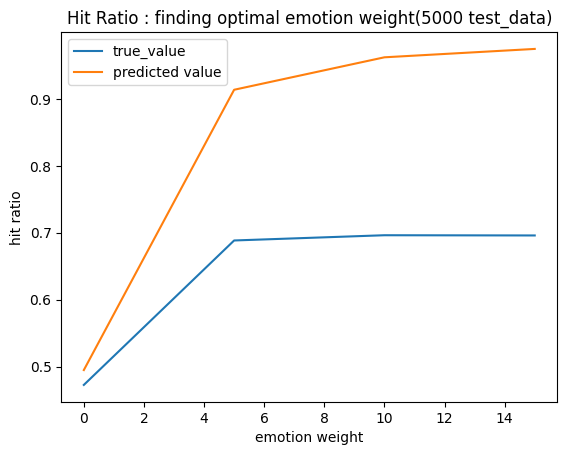

In [24]:
from matplotlib import pyplot as plt

plt.plot(weight_list,y_value)
plt.plot(weight_list,y_value2)

plt.title('Hit Ratio : finding optimal emotion weight(5000 test_data)')
plt.xlabel('emotion weight')
plt.ylabel('hit ratio')

plt.legend(['true_value','predicted value'])

plt.show()

In [107]:
# sum(result_list)/len(result_list)

# emotion weight 200 sample
# 0  0.48595505617977514
# 5  0.8339999999999997
# 10 0.885
# 15 0.9642458100558658

# with true value
# 0   0.45112359550561787
# 5   0.5995
# 10  0.6527777777777778
# 15  0.6536312849162011

0.45112359550561787